In [20]:
import pandas as pd
import numpy as np

import lightgbm as lgb

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

import feature_selection as fs

X, y = make_classification(n_samples=100_000, n_features=50, n_informative=15, n_redundant=5, n_classes=2, weights=[0.8, 0.2], random_state=322)
X = pd.DataFrame(X)
X['customer_rk'] = X.index
X.rename(columns={i: str(i) for i in X.columns}, inplace=True)

In [2]:
x_oot = X.iloc[70_000:].copy()
y_oot = y[70_000:].copy()

X = X.iloc[:70_000].copy()
y = y[:70_000].copy()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_oot.shape, y_oot.shape)

(52500, 51) (52500,)
(17500, 51) (17500,)
(30000, 51) (30000,)


### Функция для отбора TOP фичей

In [4]:
def backward_selection(argList, model, x_train, y_train, x_test, y_test, quality_loss = 0.5, n_features_to_select = -1):
    """
    Входные данные:
        - argList               -- список фичей
        - model                 -- необученная модель
        - x_train               -- фичи для обучения модели (можно передать вместе с таргетом)
        - y_train               -- таргет для обучения
        - x_test                -- test датасет
        - y_test                -- таргет для test датасета
        - quality_loss          -- максимальный процент потери качества на backward шаге относительно исходного набора фичей. Например, 0.2%. По умолчанию 0.5%
        - n_features_to_select  -- точное число фичей, которое хотим получить на выходе. -1, если ограничения на число фичей нет
    """
    backward_argList = argList.copy()   

    # fit and predict на исходном наборе фичей. Метрика на исходном наборе фичей
    model.fit(x_train[backward_argList], y_train)
    probs_test = model.predict_proba(x_test[backward_argList])[:, 1]
    roc = roc_auc_score(y_test, probs_test)
    print('ROC AUC Test initial= ', roc)

    if n_features_to_select == -1:
        while True:
            best_roc_dif = 0
            
            # fit и predict на всех фичах, кроме i. Вычисление метрики
            for i in backward_argList: 
                model.fit(x_train[backward_argList].drop(i, axis = 1), y_train)
                probs_test = model.predict_proba(x_test[backward_argList].drop(i, axis = 1))[:, 1]
                roc_new = roc_auc_score(y_test, probs_test)

                # Если качество на тесте не просело
                if (roc_new / roc >= 1 - quality_loss / 100):
                    # Сравнение падений качества и выбор фичи, которая меньше всего влияет на падение качества
                    if (roc_new / roc > best_roc_dif):
                        best_roc_dif = roc_new / roc
                        perem_del = i

            # Если потери качества весомые, то не выкидываем никакие фичи и завершаем цикл
            if (best_roc_dif == 0):
                break
            # Иначе удалям фичу из рассмотрения
            else:
                backward_argList.remove(perem_del) 
                print(f"Осталось фичей: {len(backward_argList)}, ROC_AUC = {best_roc_dif * roc}, удалена фича {perem_del}" )
            
        return backward_argList
    else:
        while len(backward_argList) > n_features_to_select:
            best_roc = 0
            
            for i in backward_argList: 
                model.fit(x_train[backward_argList].drop(i, axis = 1), y_train)
                probs_test = model.predict_proba(x_test[backward_argList].drop(i, axis = 1))[:, 1]
                roc_new = roc_auc_score(y_test, probs_test)

                if roc_new > best_roc:
                    best_roc = roc_new
                    perem_del = i

            backward_argList.remove(perem_del) 
            # Это можно закомментировать, но нужно будет убрать вывод ROC_AUC ниже
            model.fit(x_train[backward_argList], y_train)
            probs_test = model.predict_proba(x_test[backward_argList])[:, 1]
            roc_new = roc_auc_score(y_test, probs_test)
            print(f"Осталось фичей: {len(backward_argList)}, ROC_AUC = {roc_new}, удалена фича {perem_del}" )
            
        return backward_argList
    
    
def get_top_features(alg, params, x_train, y_train, x_test, y_test):
    
    if (alg == 'XGB'):
        model = XGBClassifier(n_jobs = 4)
    else:
        model = lgb.LGBMClassifier(n_jobs = 4)
        
    model.set_params(**params)
    model.fit(x_train, y_train)

    fi = pd.DataFrame({'feature': list(x_train.columns),
                       'importance': model.feature_importances_}).\
                       sort_values('importance', ascending = True)

    rocTest = []
    rocTrain = []
#     rocPredictors = [100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 24, 23, 22, 21, 20, 
#                      19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
    rocPredictors = [50, 45, 40, 35, 30, 25, 24, 23, 22, 21, 20, 
                     19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
    argList = []

    for i in rocPredictors:
        model.fit(x_train[list(fi['feature'][-i : ])], y_train)
        
        probs_test = model.predict_proba(x_test[list(fi['feature'][-i : ])])[:, 1]
        rocTest.append(roc_auc_score(y_test, probs_test))
        
        probs_train = model.predict_proba(x_train[list(fi['feature'][-i : ])])[:, 1]
        rocTrain.append(roc_auc_score(y_train, probs_train))
        
        argList.append(list(fi['feature'][-i : ]))

    
    return (model, argList[len(rocTest) - rocTest[ : : -1].index(max(rocTest)) - 1],
            rocTrain[len(rocTest) - rocTest[ : : -1].index(max(rocTest)) - 1],
            max(rocTest))

### LGBM

In [5]:
print('Объем обучающей выборки: ' + str(x_train.shape[0]) + ' наблюдений, '\
      + str(x_train.shape[1]) + ' фичей, ' + str(y_train.sum()) + ' таргета. Доля таргета: ' + str(round(100 * y_train.mean(), 3)) + '%')
print('Объем тестовой выборки: ' + str(x_test.shape[0]) + ' наблюдений и '\
      + str(x_test.shape[1]) + ' фичей, ' + str(y_test.sum()) + ' таргета. Доля таргета: ' + str(round(100 * y_test.mean(), 3)) + '%')
print('Объем OOT выборки: ' + str(x_oot.shape[0]) + ' наблюдений и '\
      + str(x_oot.shape[1]) + ' фичей.  Доля таргета: ' + str(round(100 * y_oot.mean(), 3)) + '%')

Объем обучающей выборки: 52500 наблюдений, 51 фичей, 10604 таргета. Доля таргета: 20.198%
Объем тестовой выборки: 17500 наблюдений и 51 фичей, 3555 таргета. Доля таргета: 20.314%
Объем OOT выборки: 30000 наблюдений и 51 фичей.  Доля таргета: 20.45%


In [6]:
space = {
    "n_estimators": hp.choice("n_estimators", np.arange(10, 120, 5, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(3, 8, 1, dtype=int)),
    "learning_rate": hp.choice('learning_rate', np.arange(0.005, 0.4, 0.005)),
    "objective": hp.choice("objective", ['binary']),
    "metric": hp.choice("metric", ['binary_logloss']),
    "reg_lambda": hp.choice('reg_lambda', np.arange(0.001, 0.3, 0.01)), 
    "scale_pos_weight": hp.choice("scale_pos_weight", np.arange(0.001, 10.0, 0.05)),
    "colsample_bytree": hp.choice("colsample_bytree", np.arange(0.15, 1.0, 0.05)),
    "subsample": hp.choice("subsample", np.arange(0.4, 1.0, 0.05)),
    "random_state": hp.choice("random_state", [322]),
    "n_jobs": hp.choice("n_jobs", [4])
}

def hyperparameter_tuning(params):
    clf = lgb.LGBMClassifier(**params)
    clf.fit(x_train, y_train)
    roc_auc_train = roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1])
    roc_auc_test = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    return {"loss": -(roc_auc_test - (roc_auc_train - roc_auc_test) / 2), "status": STATUS_OK}

In [7]:
# ЧАСТЬ 1: Обучение        
print('Часть 1: подбор гиперпараметров с помощью hyperopt для всех фичей')

trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

params = space_eval(space, best)
print(params)

Часть 1: подбор гиперпараметров с помощью hyperopt для всех фичей
100%|██████████| 50/50 [00:36<00:00,  1.38trial/s, best loss: -0.9812776042437348]
{'colsample_bytree': 0.8500000000000002, 'learning_rate': 0.275, 'max_depth': 7, 'metric': 'binary_logloss', 'n_estimators': 110, 'n_jobs': 4, 'objective': 'binary', 'random_state': 322, 'reg_lambda': 0.040999999999999995, 'scale_pos_weight': 7.251, 'subsample': 0.55}


##### Качество на оптимальных гиперпараметрах

In [8]:
print('\nОтбор топ фичей')
model, argList, roc_tr, roc_tst = get_top_features('LGB', params, x_train, y_train, x_test, y_test)
print('Кол-во TOP фичей = ', len(argList))
print('ROC AUC train = ' + str(roc_tr) + ', ROC AUC test = ' + str(roc_tst) + '\n')
print('TOP FEATURES:')
print(argList)

del roc_tr, roc_tst, model


Отбор топ фичей
Кол-во TOP фичей =  40
ROC AUC train = 0.999782098612526, ROC AUC test = 0.9880726119641206

TOP FEATURES:
['36', '13', '3', '4', '32', '11', '45', '49', '30', '9', '16', '37', '25', '23', '5', '21', '12', '20', '38', '48', '17', '1', '0', '22', '27', '47', '39', '24', '10', '14', '41', '33', '26', '6', '7', '18', '42', '29', '28', '43']


In [9]:
# ЧАСТЬ 2: Отбор фичей
print('Часть 2: отбор фичей Backward Selection')

model = lgb.LGBMClassifier(**params)
backward_features = backward_selection(argList, model, x_train, y_train, x_test, y_test, quality_loss = 0.5, n_features_to_select = 5)

Часть 2: отбор фичей Backward Selection
ROC AUC Test initial=  0.9880726119641206
Осталось фичей: 39, ROC_AUC = 0.9877457300354667, удалена фича 45
Осталось фичей: 38, ROC_AUC = 0.9878090690824258, удалена фича 26
Осталось фичей: 37, ROC_AUC = 0.9875427828534744, удалена фича 48
Осталось фичей: 36, ROC_AUC = 0.987448137373114, удалена фича 27
Осталось фичей: 35, ROC_AUC = 0.9877965424747313, удалена фича 24
Осталось фичей: 34, ROC_AUC = 0.9875270691217607, удалена фича 32
Осталось фичей: 33, ROC_AUC = 0.9880796922206437, удалена фича 9
Осталось фичей: 32, ROC_AUC = 0.9880534085333229, удалена фича 11
Осталось фичей: 31, ROC_AUC = 0.9875477854278841, удалена фича 17
Осталось фичей: 30, ROC_AUC = 0.9877182763912276, удалена фича 49
Осталось фичей: 29, ROC_AUC = 0.9877625532090858, удалена фича 21
Осталось фичей: 28, ROC_AUC = 0.9878474759440216, удалена фича 22
Осталось фичей: 27, ROC_AUC = 0.9880291621847734, удалена фича 12
Осталось фичей: 26, ROC_AUC = 0.9882255939170309, удалена фича

##### Подбираем заново гиперпараметры

In [10]:
x_train = x_train[backward_features]
x_test = x_test[backward_features]
x_oot = x_oot[backward_features]

In [11]:
# ЧАСТЬ 3: Подбор гиперпараметров под новые фичи
print('Часть 3: подбор гиперпараметров с помощью hyperopt для фичей Backward Selection')

trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

params = space_eval(space, best)   
print(params)

Часть 3: подбор гиперпараметров с помощью hyperopt для фичей Backward Selection
100%|██████████| 50/50 [00:12<00:00,  3.92trial/s, best loss: -0.9112979201549163]
{'colsample_bytree': 0.8000000000000003, 'learning_rate': 0.1, 'max_depth': 4, 'metric': 'binary_logloss', 'n_estimators': 100, 'n_jobs': 4, 'objective': 'binary', 'random_state': 322, 'reg_lambda': 0.12099999999999998, 'scale_pos_weight': 1.551, 'subsample': 0.6}


In [12]:
# ЧАСТЬ 4: Обучение на лучших фичах  и гиперпараметрах
print('Часть 4: Обучение на лучших фичах  и гиперпараметрах')

model = lgb.LGBMClassifier(**params)
model.fit(x_train, y_train)

model_name = 'example'
target = 'target'
model.booster_.save_model(f'model_{model_name}_{target}.txt')

Часть 4: Обучение на лучших фичах  и гиперпараметрах


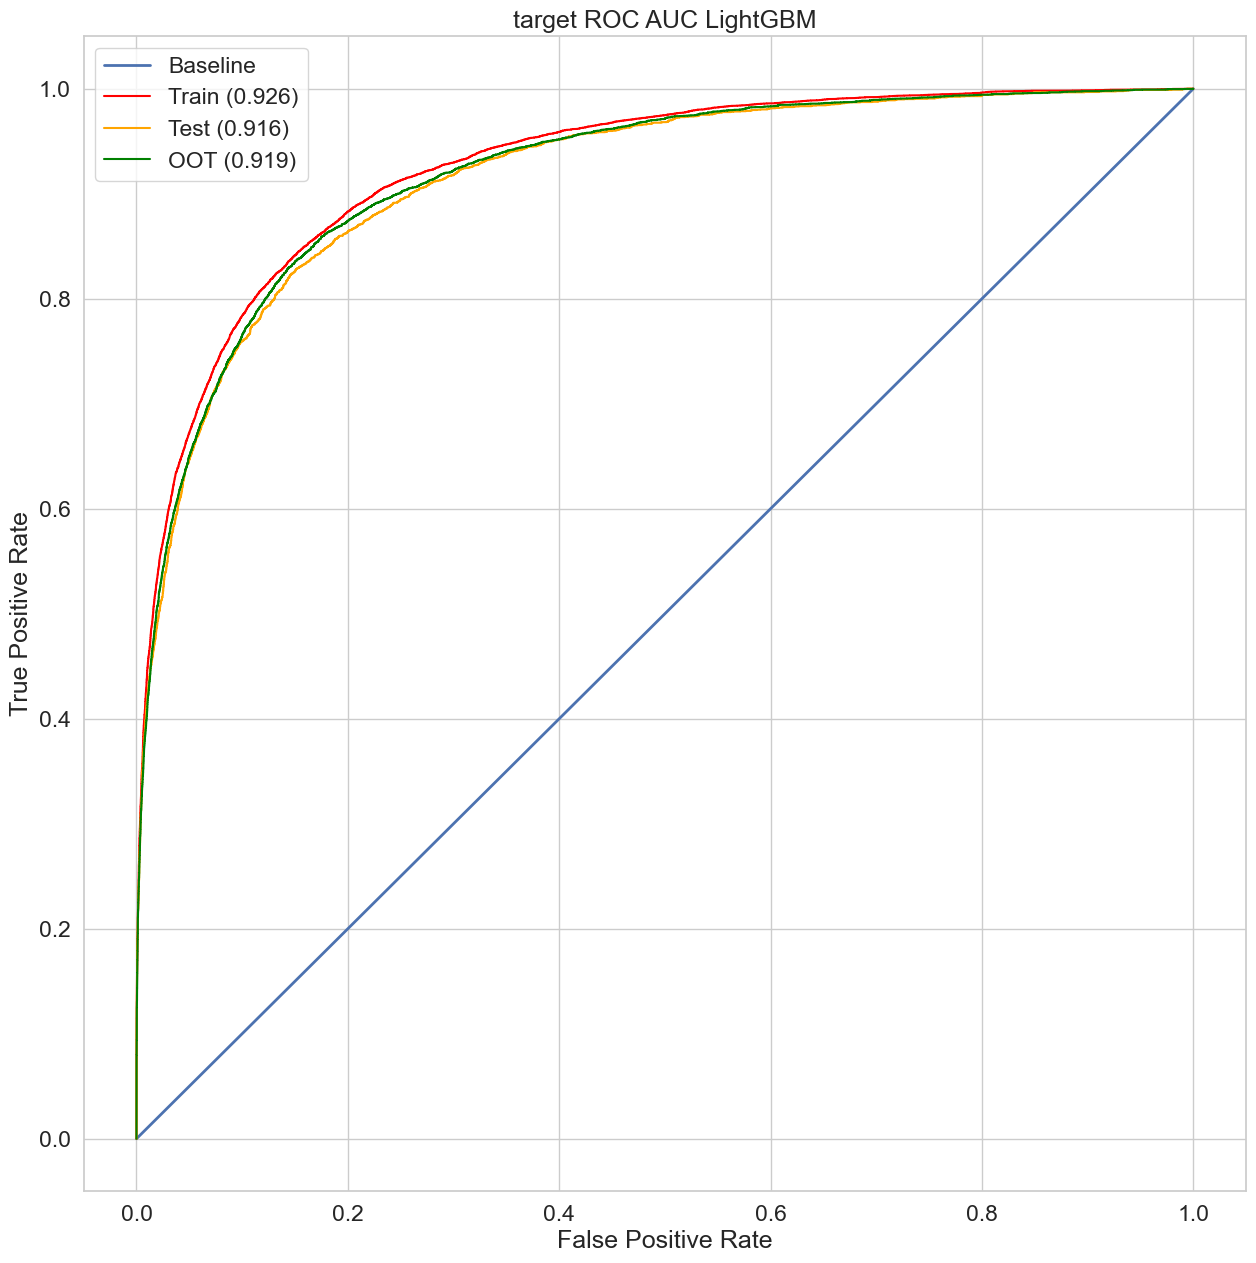

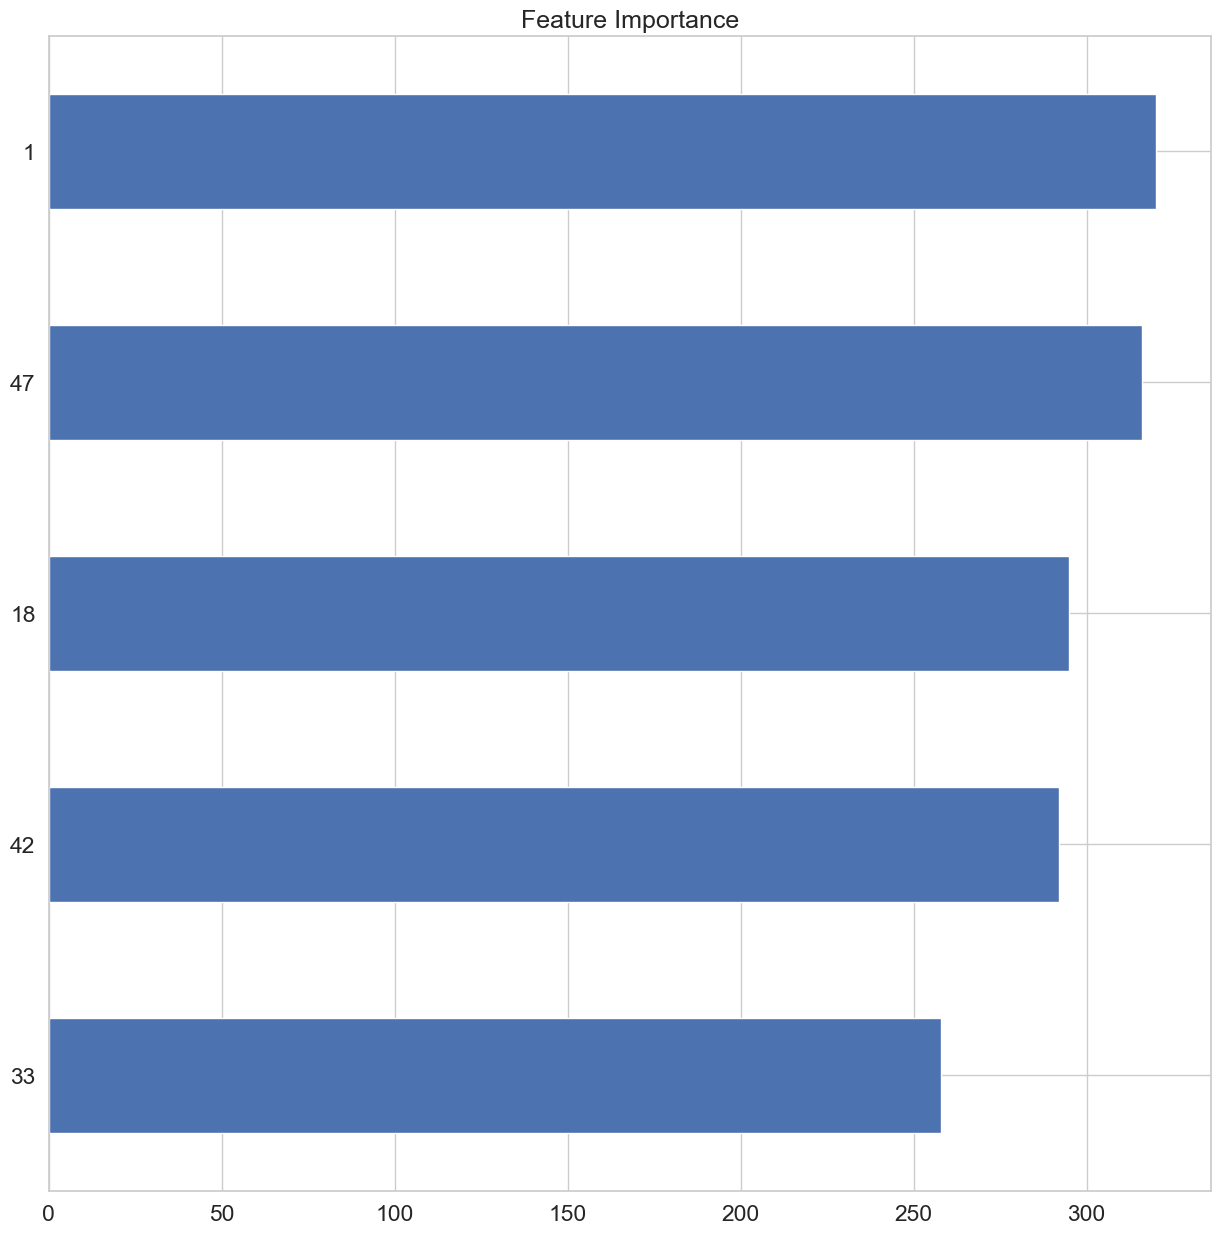

In [13]:
from roc_auc_all_data import get_roc_auc_plot

# featuresDict = {'lim': 'Лимит по активным\nдоговорам Кред. карт',
#                 'bin_dbo_4m': 'Активность по входам\nв ДБО за 4 мес.',
#                 'os': 'Долг по активным\nдоговорам Кред. карт',
#                 'share_open_r_card_otp': 'Доля Кред. карт\nото всех кред.\nпродуктов (шт.)',
#                 'time_open_last_card_r_otp': 'Число мес. с\nоткрытия Кред. карты',
#                 'age': 'Возраст',
#                 'cash_trans_amt_prev_1m_to_lim': 'Отнош. снятий за\n1 посл. месяц\nк лимиту',
#                 'w_inc_trans_amt_prev_12m': 'Взвеш. сумма\nпополнений Кред. карты\nза 2 посл. мес.',
#                 'sum_trans_amt_prev_123m': 'Сумма покупок\nпо Кред. карте\nза 3 посл. месяца',
#                 'cnt_dlq_12m': 'Кол-во просрочек\nза посл. год',
#                 'cat_city_population': 'Размер города\nпроживания',
#                 'count_prod_otp_early_repayment': 'Кол-во досрочных\nпогашений',
#                }
featuresDict = {}
for feature in x_train.columns:
    featuresDict[feature] = feature

get_roc_auc_plot(x_train, y_train, x_test, y_test, x_oot, y_oot, backward_features, featuresDict, model, 'LightGBM', target)

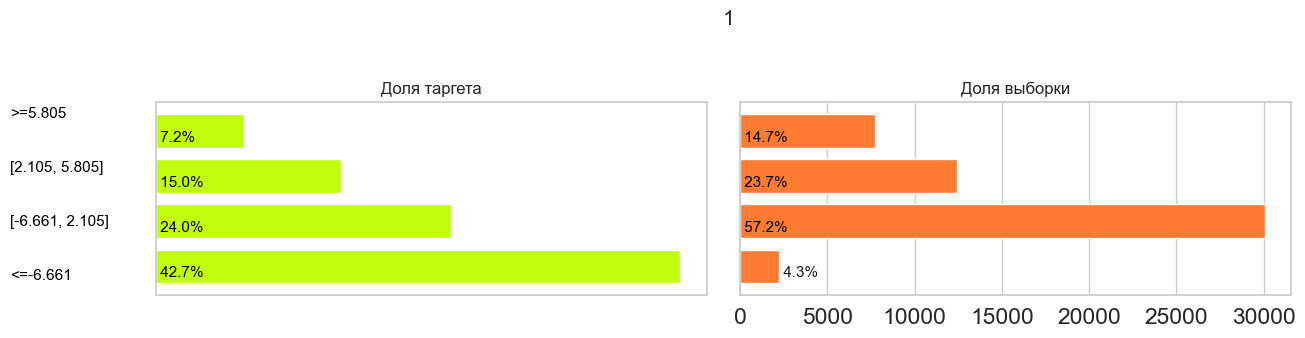

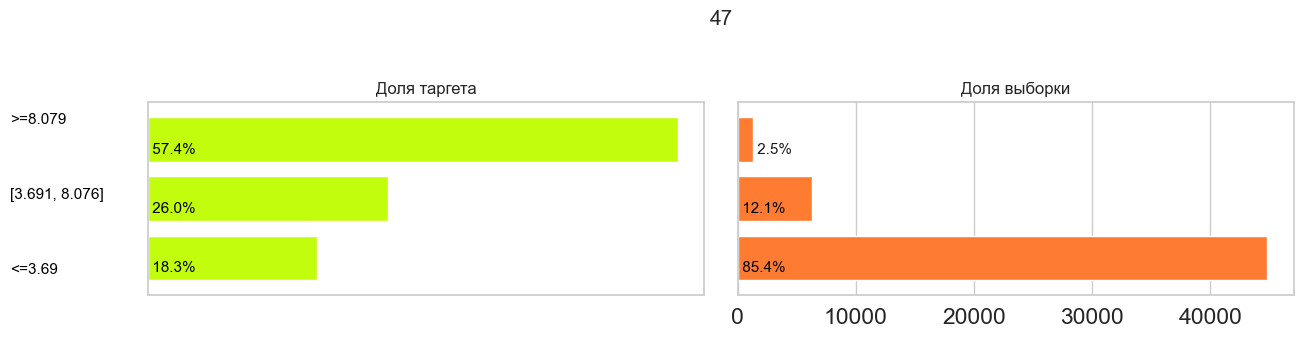

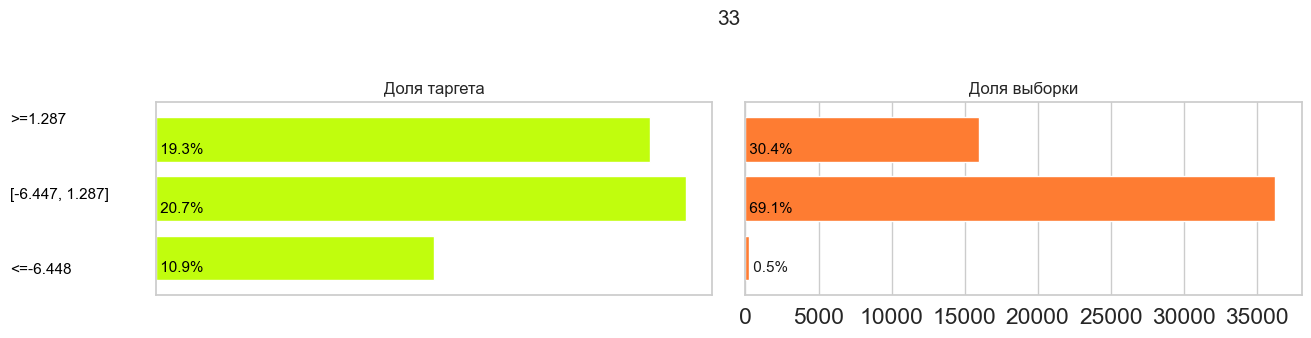

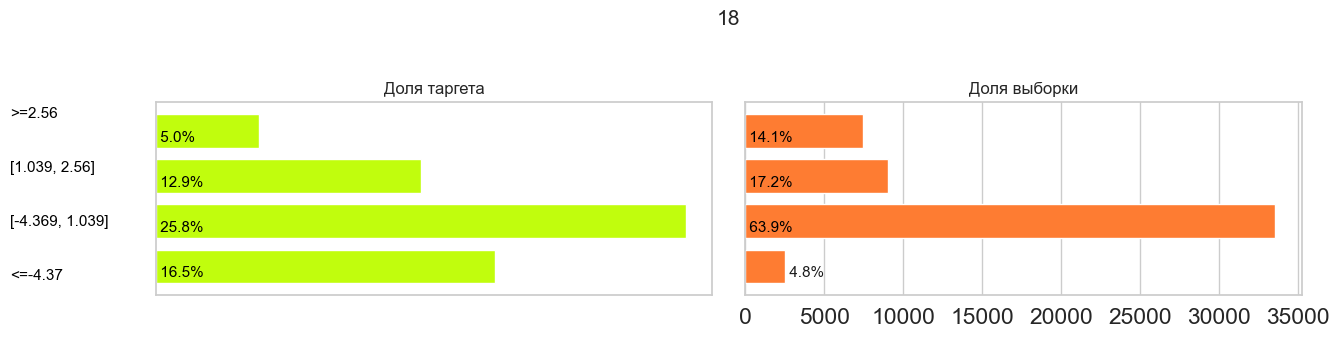

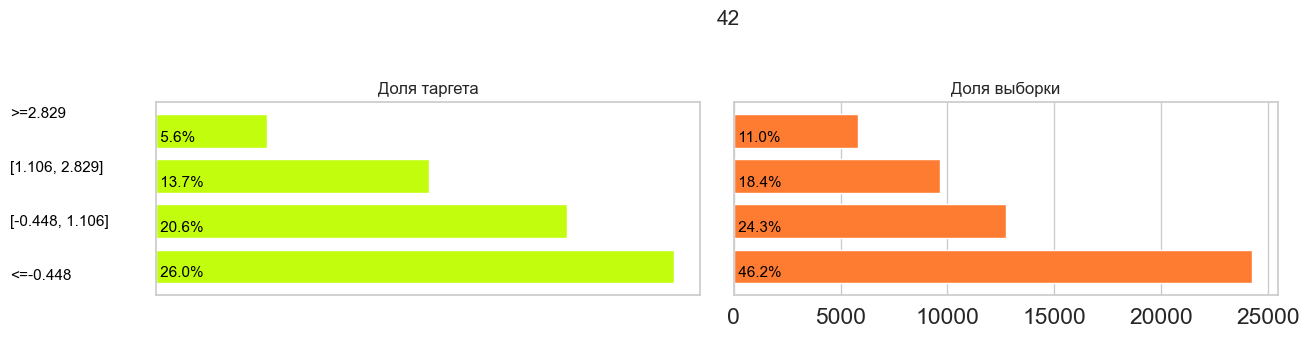

In [14]:
x_train.reset_index(drop=True, inplace=True)

import Trees_binning as binning

for name in backward_features:
    r = binning.describe_target_rate(x_train, pd.DataFrame(y_train), name, 0, 2, 0.05, 0.005)
    binning.render_target_rate(r, featuresDict[name], len(x_train[name].to_numpy()))

In [15]:
import woe_iv


def bc(df, bucket_boundary):
    df['Bucket'] = 0
    df['MIN_PROB'] = 0
    df['MAX_PROB'] = 0   
    
    share_target = df['Fact Target'].mean()
    
    for i in range(bucket_boundary.shape[0]):
        if (i == 0):
            max_b = 1
            min_b = bucket_boundary['MIN_VALUE'].loc[i]
        else:
            max_b = bucket_boundary['MIN_VALUE'].loc[i - 1]
            min_b = bucket_boundary['MIN_VALUE'].loc[i] 
        
        df['Bucket'][(df['PROB'] < max_b) & (df['PROB'] >= min_b)] = i
        df['MIN_PROB'][(df['PROB'] < max_b) & (df['PROB'] >= min_b)] = min_b
        df['MAX_PROB'][(df['PROB'] < max_b) & (df['PROB'] >= min_b)] = max_b
    
    # По всем
    stat1 = df.groupby(by = ['Bucket']).agg({'MIN_PROB': 'min', 'MAX_PROB': 'max', 
                                             'PROB': 'count', 'Fact Target': 'mean',
                                             'Probability Target': 'mean'})  
    stat1 = stat1.reset_index()
    stat1.rename(columns = {'Fact Target': 'Доля таргета в бакете', 'PROB': 'Объем бакета',
                            'Probability Target': 'Средний скор'}, inplace = True)
    
    stat1['Scale'] = stat1['Средний скор'] / stat1['Доля таргета в бакете']
    
    stat1['MIN_PROB'][stat1['Bucket'] == 0] = float(stat1['MAX_PROB'][stat1['Bucket'] == 1])
    
    stat1['Количество таргета'] = stat1['Доля таргета в бакете'] * stat1['Объем бакета']
    stat1['Количество таргета'] = stat1['Количество таргета'].astype(int)
    stat1['Доля бакета'] = stat1['Объем бакета'] / stat1['Объем бакета'].sum()
    stat1['Доля таргета от выборки'] = stat1['Количество таргета'] / stat1['Количество таргета'].sum()
    stat1['Lift'] = stat1['Доля таргета в бакете'] / share_target

    
    return stat1[['Bucket', 'MIN_PROB', 'MAX_PROB', 'Объем бакета', 'Доля бакета',
                  'Количество таргета', 'Доля таргета в бакете', 'Доля таргета от выборки', 'Lift', 
                  'Средний скор', 'Scale']]

In [16]:
import warnings
warnings.filterwarnings('ignore')

prob_data = pd.DataFrame({'Probability Target': model.predict_proba(x_oot[backward_features])[:, 1], # Обычно здесь скоры с OOT
                          'Fact Target': y_oot}) # и таргет с OOT
prob_data['PROB'] = round(prob_data['Probability Target'], 6)

#вычисляем бакеты
bucket_boundary = woe_iv.get_bucket(prob_data[['Fact Target', 'PROB']], 'Fact Target', 'PROB', False, 
                             int(prob_data.shape[0] / 40), 0.05)

#рассчитываем статистики
stat_data = bc(prob_data, bucket_boundary)

In [17]:
display(stat_data)

,Bucket,MIN_PROB,MAX_PROB,Объем бакета,Доля бакета,Количество таргета,Доля таргета в бакете,Доля таргета от выборки,Lift,Средний скор,Scale
0,0,0.887830,1.000000,1328,0.044267,1296,0.975904,0.211247,4.772145,0.942585,0.965858
1,1,0.774408,0.887830,1134,0.037800,992,0.874780,0.161695,4.277651,0.830534,0.949421
2,2,0.644879,0.774408,1238,0.041267,904,0.730210,0.147351,3.570709,0.707660,0.969119
3,3,0.545324,0.644879,1085,0.036167,610,0.562212,0.099430,2.749203,0.594413,1.057276
4,4,0.425769,0.545324,1585,0.052833,658,0.415142,0.107253,2.030034,0.482310,1.161795
5,5,0.001071,0.425769,23630,0.787667,1675,0.070884,0.273024,0.346623,0.122078,1.722211


In [18]:
stat_data.to_excel(f'stat_data_model_{model_name}_{target}.xlsx')

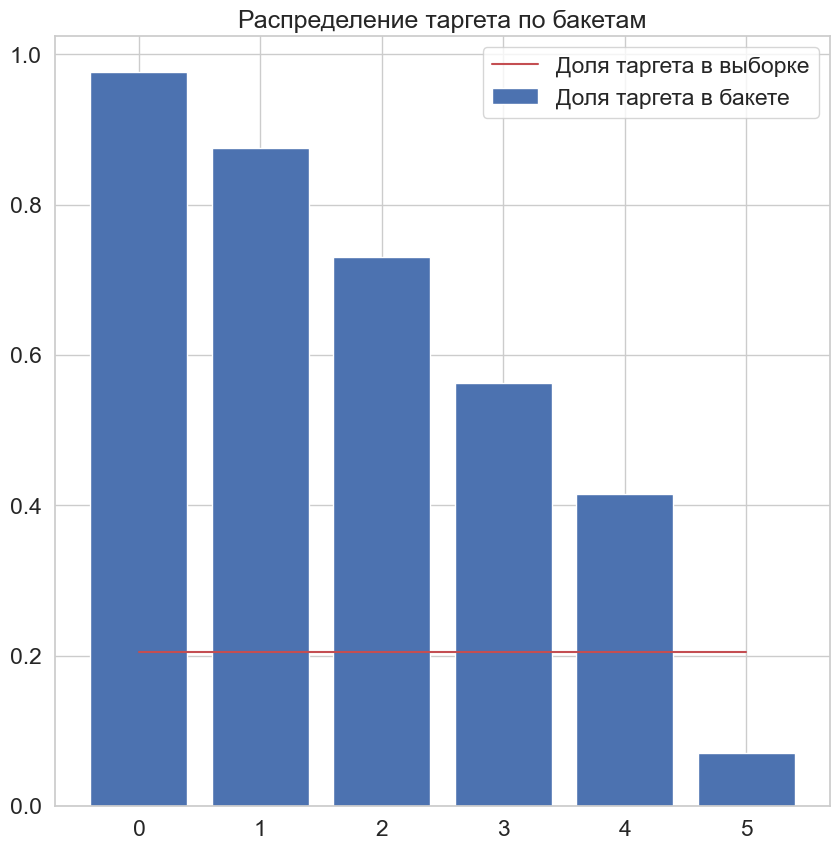

In [21]:
plt.subplots(figsize = (10, 10))

plt.bar(stat_data['Bucket'], stat_data['Доля таргета в бакете'], label = 'Доля таргета в бакете')
plt.plot(stat_data['Bucket'], stat_data.shape[0] * [prob_data['Fact Target'].mean()], 'r', 
                                                                    label = 'Доля таргета в выборке')
plt.xticks(stat_data['Bucket'])
plt.title('Распределение таргета по бакетам')
plt.legend(loc = 'upper right')


plt.show()

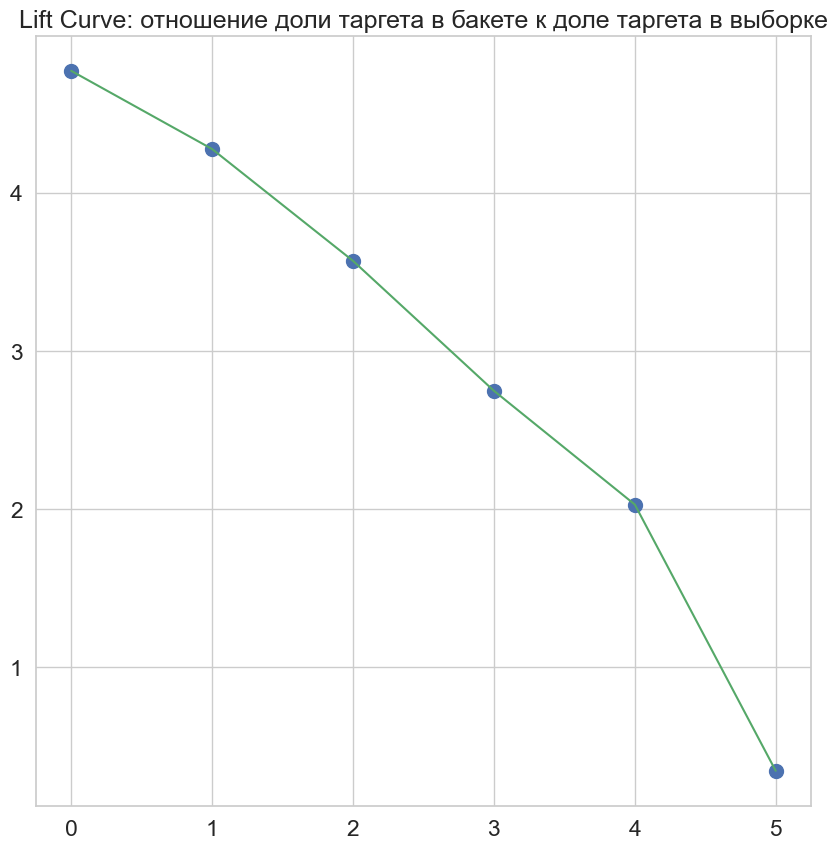

In [22]:
plt.subplots(figsize = (10, 10))

plt.scatter(stat_data['Bucket'], stat_data['Lift'], s = 100)
plt.plot(stat_data['Bucket'], stat_data['Lift'], 'g')
plt.xticks(stat_data['Bucket'])
plt.title('Lift Curve: отношение доли таргета в бакете к доле таргета в выборке')

plt.show()

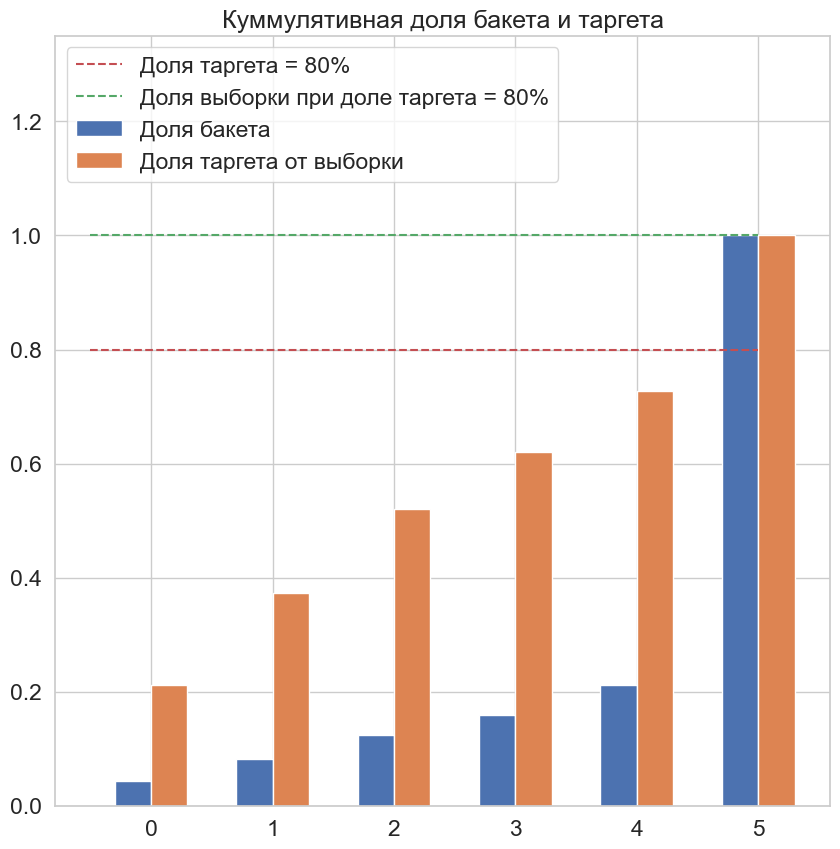

In [23]:
plt.subplots(figsize = (10, 10))

plt.bar(stat_data['Bucket'] - 0.15, stat_data['Доля бакета'].cumsum(), width = 0.3, label = 'Доля бакета')
plt.bar(stat_data['Bucket'] + 0.15, stat_data['Доля таргета от выборки'].cumsum(), width = 0.3, 
                                label = 'Доля таргета от выборки')
plt.plot([-0.5, stat_data['Bucket'].max()], [0.8, 0.8], '--r', label = 'Доля таргета = 80%')

bound = list(stat_data['Доля бакета'].cumsum())\
              [list(stat_data['Доля таргета от выборки'].cumsum() >= 0.8).index(True)]

plt.plot([-0.5, stat_data['Bucket'].max()], [bound, bound], '--g', 
           label = 'Доля выборки при доле таргета = 80%')

plt.xticks(stat_data['Bucket'])
plt.title('Куммулятивная доля бакета и таргета')
plt.ylim((0, 1.35))
plt.legend(loc= "upper left")

plt.show()

In [25]:
from psi_calc import *

scores_train = pd.Series(model.predict_proba(x_train[backward_features])[:, 1])
scores_test = pd.Series(model.predict_proba(x_test[backward_features])[:, 1])

In [26]:
bnds, shrs = get_split(scores_train, n_buckets=10)
bnds = np.array(bnds)
shrs = np.array(shrs)

display(bnds)
display(shrs)

INFO:Разбиение на бакеты для PSI/CSI прошло успешно


array([0.02171588, 0.03724401, 0.05683766, 0.08364902, 0.12317902,
       0.18427011, 0.28423372, 0.44969233, 0.7149307 ])

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [27]:
calc_psi(scores_train, bnds, shrs)

0.0

In [28]:
calc_psi(scores_test, bnds, shrs)

0.0013079251348601228

,Feature,Cummulative ROC,Uplift ROC Abs,Precision Left,Recall Right,Uplift ROC Rel2,Uplift ROC Rel
0,18,0.651372,0.651372,0.823921,0.304319,0.007791,1.000000
1,1,0.749217,0.097845,0.850415,0.409091,0.002612,0.150214
2,42,0.747266,-0.001952,0.849986,0.407299,0.027277,-0.002996
3,47,0.890880,0.143614,0.912402,0.653904,0.033702,0.220479
4,33,0.925645,0.034765,0.930757,0.726518,inf,0.053372


INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


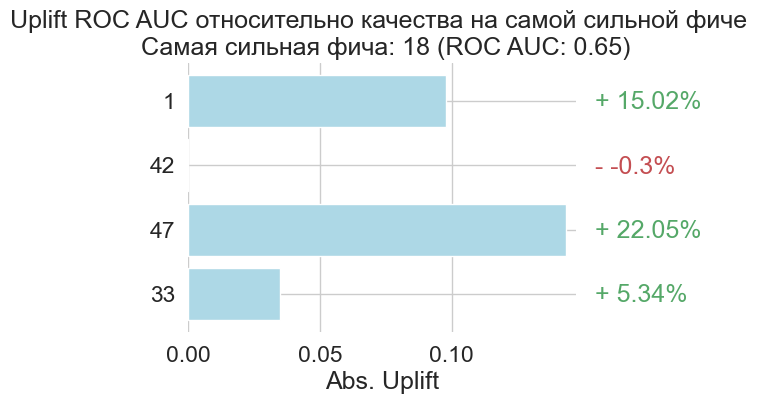

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


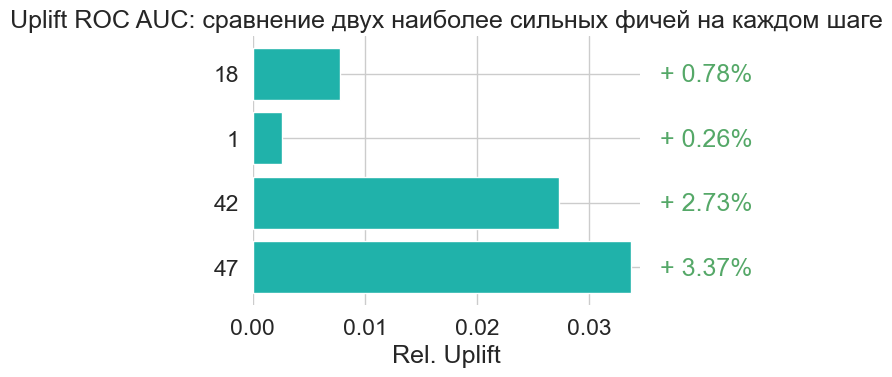

In [29]:
import feature_importance as fi

df_roc_uplift = fi.roc_uplift_by_features(model, backward_features, x_train, y_train)
df_roc_uplift['Feature'] = df_roc_uplift['Feature'].apply(lambda x: featuresDict[x].replace('\n', ' '))
display(df_roc_uplift)

fi.plot_roc_uplift_by_features(df_roc_uplift, {})